### Graham Kerr
#### graham.s.kerr@NASA.gov; kerrg@cua.edu

<H1 font size="+3" style="color:red">
O I in Flares<br>
-- IRIS SG Basic Errors <br>
</H1>

<b>This notebook will</b>
> - Read in pre-saved pickle files of SG data
> - Calculate the photon counting and readout errors
> - Plot some examples





---
### <b style="color:blue"> Some set up </b>

***Import Modules***

> - Note that here I have called a module called 'utils' that contains a few functions that I have collected. The python session knows where they are held as I insert their location to the path. You will have to modify that line to point to where you put utils.

In [1]:
##
## Import various modules -- can tidy up later
##
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib tk
import sys
sys.path.insert(0,'/Users/gskerr1/Documents/Research/Melissa_OI_IRIS/MelissaInternship_OIFlares/')
import utils
import os
import re
from scipy import io
import pickle
import cmocean
import copy
import iris_lmsalpy
# import astropy
import pandas as pd
# import hissw
# from astropy.coordinates import SkyCoord
# import astropy.units as u
# from sunpy.coordinates import frames
# import sunpy.map

---
### <b style="color:blue"> Set up some plotting parameters </b>
> - These are just my personal preferences for plot styles... you dont need to use them, or can change them my modifying the params in the function, or generally changing rcParams (check the matplotlib docs)

In [2]:
plot_dict = utils.plotsetup(font_size = 22)
plt.rcParams.update(plot_dict)

---
### <b style="color:blue"> Load the data </b>


In [19]:
dir1 = '/Users/gskerr1/Documents/Research/Melissa_OI_IRIS/2014_10_25_1500/'
file_sg = dir1+'IRIS_SG_2014_Oct_25_mgiik_expcorr.pkl'
with open(file_sg, 'rb') as output:  
    sg_mgiik_dict = pickle.load(output)
file_sg = dir1+'IRIS_SG_2014_Oct_25_oi_expcorr.pkl'
with open(file_sg, 'rb') as output:  
    sg_oi_dict = pickle.load(output)
file_sg = dir1+'IRIS_SG_2014_Oct_25_oi_errs.pkl'
with open(file_sg, 'rb') as output:  
    sg_oi_dict_err = pickle.load(output)    
exptimecorr = True

In [4]:
sg_mgiik_dict['hdr']['exptimen'].shape

(2040, 1)

In [5]:
sg_mgiik_dict['data'].shape

(387, 2040, 1015, 1)

In [6]:
ny = (sg_mgiik_dict['data'].shape)[0]
nexp = (sg_mgiik_dict['data'].shape)[1]
nras = (sg_mgiik_dict['data'].shape)[3]

nwvl_oi = (sg_oi_dict['data'].shape)[2]
nwvl_mgiik = (sg_mgiik_dict['data'].shape)[2]

In [7]:
data_mgiik = copy.deepcopy(sg_mgiik_dict['data'])
data_oi = copy.deepcopy(sg_oi_dict['data'])

index_mgiik = copy.deepcopy(sg_mgiik_dict['hdr'])
index_oi = copy.deepcopy(sg_oi_dict['hdr'])

---
### <b style="color:blue"> Calculate the errors </b>


***Convert back to DN/px***

In [8]:
if exptimecorr == True:
    for eind in range(nexp):
        for rind in range(nras):
            data_mgiik[:,eind,:,rind]*=index_mgiik['exptimen'][eind,rind]
            data_oi[:,eind,:,rind]*=index_oi['exptimef'][eind,rind]

<ipython-input-8-fd00c959b5a7>:4: RuntimeWarning: invalid value encountered in multiply
  data_mgiik[:,eind,:,rind]*=index_mgiik['exptimen'][eind,rind]
<ipython-input-8-fd00c959b5a7>:5: RuntimeWarning: invalid value encountered in multiply
  data_oi[:,eind,:,rind]*=index_oi['exptimef'][eind,rind]


***Find the errors***

In [9]:
err_dn_mgiik = np.zeros([ny,nexp,nwvl_mgiik,nras],dtype=np.float64)
err_dn_s_mgiik = np.zeros([ny,nexp,nwvl_mgiik,nras],dtype=np.float64)

err_dn_oi = np.zeros([ny,nexp,nwvl_oi,nras],dtype=np.float64)
err_dn_s_oi = np.zeros([ny,nexp,nwvl_oi,nras],dtype=np.float64)

for i in range(nras):
    tmp1_oi, tmp2_oi = utils.IRIS_SG_BasicErrors(data_oi[:,:,:,i], 
                                                     wreg = 'FUV', 
                                                     exptime=index_oi['exptimef'][:,i], 
                                                     verbose = False, sitnstare=True)
    err_dn_oi[:,:,:,i] = tmp1_oi
    err_dn_s_oi[:,:,:,i] = tmp2_oi

    tmp1_mgiik, tmp2_mgiik = utils.IRIS_SG_BasicErrors(data_mgiik[:,:,:,i], 
                                                           wreg = 'NUV', 
                                                           exptime=index_mgiik['exptimen'][:,i], 
                                                           verbose = False,sitnstare=True)
    err_dn_mgiik[:,:,:,i] = tmp1_mgiik
    err_dn_s_mgiik[:,:,:,i] = tmp2_mgiik

***Save the errors***

In [ ]:
dirout = '/Users/gskerr1/Documents/Research/Melissa_OI_IRIS/MelissaInternship_OIFlares/'

err_dict_oi = {
            'err_dn':err_dn_oi,
            'err_dn_s':err_dn_s_oi,
            'index':index_oi}
file_errs = dirout+'IRIS_SJI_2014_Oct_25_oi_errors.pkl'
with open(file_errs, 'wb') as output:  # Overwrites any existing file.
    pickle.dump(err_dict_oi, output, pickle.HIGHEST_PROTOCOL)

err_dict_mgiik = {
            'err_dn':err_dn_mgiik,
            'err_dn_s':err_dn_s_mgiik,
            'index':index_mgiik}
file_errs = dirout+'IRIS_SJI_2014_Oct_25_mgiik_errors.pkl'
with open(file_errs, 'wb') as output:  # Overwrites any existing file.
    pickle.dump(err_dict_mgiik, output, pickle.HIGHEST_PROTOCOL)

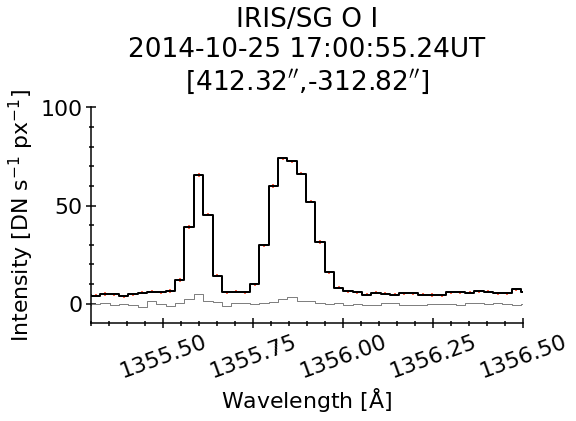

In [43]:
savepng = False

dirout = './'
fname_out = 'IRISSG_OI_CI_errs_2014_Oct_25_TEST'

sind = 0
yind = 210
# data = copy.deepcopy(sg_oi_dict['data'])

t1 = 1000
t2 = nexp

xrange = [1355.3,1356.5]
yrange = [-10, 100]

xsize = 8
ysize = 4

dx = 0.75
dy = 0.75
y1 = 0.05
x1 = 0.05
sx = 0.05
sy = 0.25

counter = 0
# for tind in range(t1,t2):
for tind in range(1369,1370):
    
    fig = plt.figure(figsize=(xsize, ysize))
    ax1 = fig.add_axes([x1, y1+0*sy+0*dy, dx, dy])

    ax1.set_xlim(xrange[0], xrange[-1])
    ax1.set_ylim(yrange[0], yrange[-1])

    ax1.set_xlabel('Wavelength [$\mathrm{\AA}$]')
    ax1.set_ylabel('Intensity [DN s$^{-1}$ px$^{-1}$]')
    ax1.xaxis.set_tick_params(rotation=20)
    ax1.tick_params(which='both', direction='inout')
    
    
#     ax1.errorbar(sg_oi_dict['wl'][:,sind], 
#              sg_oi_dict['data'][yind,tind,:,sind],
#              xerr = 0.0, yerr = sg_oi_dict_err['err_dn_s'][yind,eind,:,sind],
#              color = 'black',
#              drawstyle = 'steps-mid',
#              ecolor = 'blue',
#              elinewidth = 2, 
#              capsize = 0, capthick = 0, 
#              errorevery = 1,
#              linewidth = 1)
    
    ax1.errorbar(sg_oi_dict['wl'][:,sind], 
             sg_oi_dict['data'][yind,tind,:,sind],
             xerr = 0.0, yerr = err_dn_s_oi[yind,eind,:,sind],
             color = 'black',
             drawstyle = 'steps-mid',
             ecolor = 'tomato',
             elinewidth = 2, 
             capsize = 0, capthick = 0, 
             errorevery = 1,
             linewidth = 2)
    
    ax1.plot(sg_oi_dict['wl'][:,sind], 
             sg_oi_dict['data'][yind,0,:,sind],
             color = 'grey',
             drawstyle = 'steps-mid',
             linewidth = 1)
    
    ax1.set_title('IRIS/SG O I\n'+sg_oi_dict['hdr']['dateobs'][tind,sind]+
                  'UT\n[%0.2f$^{\prime\prime}$,%0.2f$^{\prime\prime}$]' 
                  %(sg_oi_dict['slitposx'][tind],sg_oi_dict['slitposy'][yind,tind] ))
    
    if savepng == True:
        plt.savefig(fname_out+'_%04d.png' %(counter), format='png', bbox_inches = 'tight', dpi=300)
    
    counter+= 1

    plt.show()

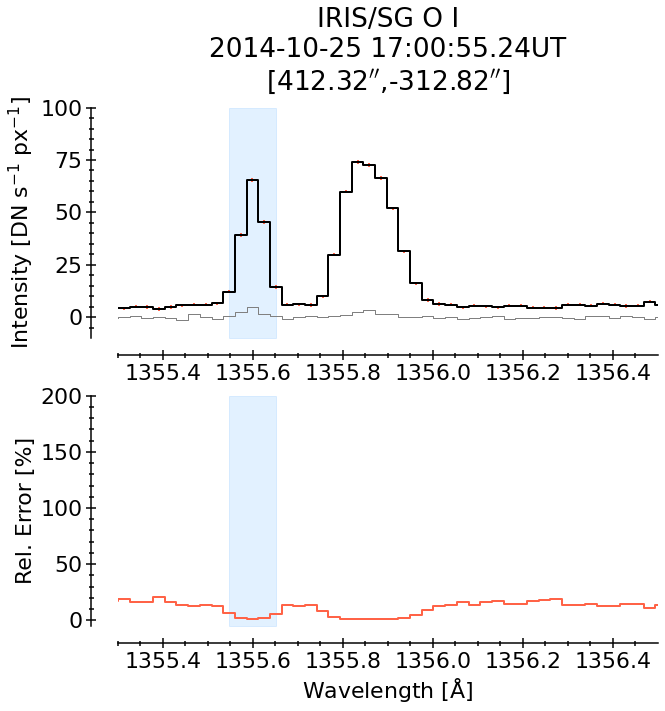

In [66]:
savepng = False

dirout = './'
fname_out = 'IRISSG_OI_CI_relerrs_2014_Oct_25_TEST'

sind = 0
yind = 210
# data = copy.deepcopy(sg_oi_dict['data'])

t1 = 1000
t2 = nexp

xrange = [1355.30,1356.5]
yrange = [-10, 100]
yrange_rel = [-5, 200]


xsize = 10
ysize = 8

dx = 0.75
dy = 0.40
y1 = 0.05
x1 = 0.05
sx = 0.05
sy = 0.10

counter = 0
# for tind in range(t1,t2):
for tind in range(1369,1370):
    
    fig = plt.figure(figsize=(xsize, ysize))
    ax1 = fig.add_axes([x1, y1+1*sy+1*dy, dx, dy])
    ax2 = fig.add_axes([x1, y1+0*sy+0*dy, dx, dy])

    ax1.set_xlim(xrange[0], xrange[-1])
    ax1.set_ylim(yrange[0], yrange[-1])
    ax2.set_xlim(xrange[0], xrange[-1])
    ax2.set_ylim(yrange_rel[0], yrange_rel[-1])

#     ax1.set_xlabel('Wavelength [$\mathrm{\AA}$]')
    ax1.set_ylabel('Intensity [DN s$^{-1}$ px$^{-1}$]')
    ax1.xaxis.set_tick_params(rotation=20)
    ax1.tick_params(which='both', direction='inout')
    
    ax2.set_xlabel('Wavelength [$\mathrm{\AA}$]')
    ax2.set_ylabel('Rel. Error [%]')
    ax2.xaxis.set_tick_params(rotation=20)
    ax2.tick_params(which='both', direction='inout')
    
    
    ax1.errorbar(sg_oi_dict['wl'][:,sind], 
             sg_oi_dict['data'][yind,tind,:,sind],
             xerr = 0.0, yerr = err_dn_s_oi[yind,eind,:,sind],
             color = 'black',
             drawstyle = 'steps-mid',
             ecolor = 'tomato',
             elinewidth = 2, 
             capsize = 0, capthick = 0, 
             errorevery = 1,
             linewidth = 2)
    
    ax1.plot(sg_oi_dict['wl'][:,sind], 
             sg_oi_dict['data'][yind,0,:,sind],
             color = 'grey',
             drawstyle = 'steps-mid',
             linewidth = 1)
    
    ax2.plot(sg_oi_dict['wl'][:,sind], 
             err_dn_s_oi[yind,eind,:,sind]/np.abs(sg_oi_dict['data'][yind,tind,:,sind])*100,
             color = 'tomato',
             drawstyle = 'steps-mid',
             linewidth = 2)
    
    ax1.set_title('IRIS/SG O I\n'+sg_oi_dict['hdr']['dateobs'][tind,sind]+
                  'UT\n[%0.2f$^{\prime\prime}$,%0.2f$^{\prime\prime}$]' 
                  %(sg_oi_dict['slitposx'][tind],sg_oi_dict['slitposy'][yind,tind] ))
    
    ax1.spines["left"].set_position(("axes",-0.05))
    ax1.spines["bottom"].set_position(("axes",-.075))
    ax2.spines["left"].set_position(("axes",-0.05))
    ax2.spines["bottom"].set_position(("axes",-.075))
    
    wind1 = np.abs(sg_oi_dict['wl'][:,sind] - 1355.55).argmin()
    wind2 = np.abs(sg_oi_dict['wl'][:,sind] - 1355.65).argmin()
    ax1.fill_between(sg_oi_dict['wl'][wind1:wind2+1,sind], yrange[0], yrange[-1], color = 'dodgerblue', alpha = 0.125)
    ax2.fill_between(sg_oi_dict['wl'][wind1:wind2+1,sind], yrange_rel[0], yrange_rel[-1], color = 'dodgerblue', alpha = 0.125)


    if savepng == True:
        plt.savefig(fname_out+'_%04d.png' %(counter), format='png', bbox_inches = 'tight', dpi=300)
    
    counter+= 1

    plt.show()

In [20]:
sg_oi_dict_err.keys()

dict_keys(['err_dn', 'err_dn_s', 'index'])

In [30]:
sg_oi_dict['slitposy'].shape

(387, 2040)